# Get elevation data given lat and lon 

## We will use elevation data from https://www.landfire.gov/version_download.php# 

In [1]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [6]:
#File paths
data_path      = '/Users/hrh/Desktop/AI/erdos/rapower_data/'
ca_gridpath    = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data_including_land_cover.csv'
elevation_datapath = data_path + 'LF2020_Elev_220_CONUS/'

### Read lats and lons for CA into a GeoDataframe

In [3]:
df_main             = pd.read_csv(ca_gridpath)
ca_grid             = df_main.loc[df_main['State']=='CA']
# ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['Latitude'], ca_grid['Longitude']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))

((32.61826367503021, 41.98152421968207),
 (-124.36136888868832, -114.14033495079964))

In [4]:
# Create a GeoDataFrame for California coordinates
geometry = [Point(xy) for xy in ca_coords]
# ca_gdf   = gpd.GeoDataFrame(geometry=geometry)
ca_gdf   = gpd.GeoDataFrame({'geometry': [Point(lon, lat) for lat, lon in ca_coords]
                           }, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system
ca_gdf

,geometry
0,POINT (-122.08477 37.40518)
1,POINT (-122.27153 37.84717)
2,POINT (-121.56023 37.15445)
3,POINT (-122.08683 38.00698)
4,POINT (-122.14264 38.08989)
...,...
4939,POINT (-114.35780 34.29379)
4940,POINT (-114.35780 34.39236)
4941,POINT (-114.24907 34.19523)
4942,POINT (-114.24907 34.29379)


### Read elevation data 

In [7]:
#elevation data path 
elevation_tif_path = elevation_datapath + 'Tif/LC20_Elev_220.tif'
# Open the elevation raster
# Check the CRS of the GeoDataFrame and the Raster
with rasterio.open(elevation_tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster Bounds: {src.bounds}")

print(f"GeoDataFrame CRS: {ca_gdf.crs}")

Raster CRS: EPSG:5070
Raster Bounds: BoundingBox(left=-2362395.0, bottom=221265.0, right=2327655.0, top=3267405.0)
GeoDataFrame CRS: EPSG:4326


In [8]:
with rasterio.open(elevation_tif_path) as src:
    #Convert the ca_gdf dataframe to the crs of the source
    ca_gdf = ca_gdf.to_crs(src.crs)
    # Mask the raster with the GeoDataFrame to get the elevation values for California coordinates
    # out_image, out_transform = mask(src, [g for g in ca_gdf['geometry'].values], crop=True)
    # ca_elevation_data            = out_image[0]  # Assuming elevation data is in the first band
    # Sample the raster at the given points
    ca_elevation_values = [val[0] for val in src.sample([(geom.x, geom.y) for geom in ca_gdf.geometry])]


In [9]:
len(ca_elevation_values)

4944

In [10]:
# Create a DataFrame from the sampled elevation values
ca_elevation = pd.DataFrame({
    'lat': [geom.y for geom in ca_gdf.geometry],
    'lon': [geom.x for geom in ca_gdf.geometry],
    'elevation': ca_elevation_values
})

In [11]:
ca_elevation

,lat,lon,elevation
0,1.908088e+06,-2.258574e+06,13
1,1.960197e+06,-2.260812e+06,29
2,1.868657e+06,-2.221735e+06,639
3,1.973059e+06,-2.240466e+06,5
4,1.983319e+06,-2.242613e+06,17
...,...,...,...
4939,1.409284e+06,-1.666544e+06,673
4940,1.420099e+06,-1.664429e+06,281
4941,1.396567e+06,-1.658898e+06,156
4942,1.407383e+06,-1.656795e+06,363


###  Convert the DataFrame back to a GeoDataFrame with the original CRS (EPSG:4326)

In [12]:
#CRS transformation after creating a geodata frame
ca_elevation_gdf = gpd.GeoDataFrame(ca_elevation, geometry=gpd.points_from_xy(ca_elevation.lon, ca_elevation.lat),crs='EPSG:5070') # Set to raster's CRS to match the sampling
print('The coordinate reference system of ca_elevation_gdf is:',ca_elevation_gdf.crs)

# Now, reproject to EPSG:4326
ca_elevation_gdf = ca_elevation_gdf.to_crs("EPSG:4326")
print('The coordinate reference system of ca_elevation_gdf is:',ca_elevation_gdf.crs)

# Assuming 'ca_elevation_gdf' has been correctly reprojected to EPSG:4326
ca_elevation_gdf['lat'] = ca_elevation_gdf.geometry.y
ca_elevation_gdf['lon'] = ca_elevation_gdf.geometry.x

The coordinate reference system of ca_elevation_gdf is: EPSG:5070
The coordinate reference system of ca_elevation_gdf is: EPSG:4326


In [13]:
# Verify the transformation
ca_elevation_gdf

,lat,lon,elevation,geometry
0,37.405176,-122.084769,13,POINT (-122.08477 37.40518)
1,37.847173,-122.271530,29,POINT (-122.27153 37.84717)
2,37.154450,-121.560230,639,POINT (-121.56023 37.15445)
3,38.006981,-122.086832,5,POINT (-122.08683 38.00698)
4,38.089888,-122.142635,17,POINT (-122.14264 38.08989)
...,...,...,...,...
4939,34.293795,-114.357804,673,POINT (-114.35780 34.29379)
4940,34.392355,-114.357804,281,POINT (-114.35780 34.39236)
4941,34.195234,-114.249069,156,POINT (-114.24907 34.19523)
4942,34.293795,-114.249069,363,POINT (-114.24907 34.29379)


### Finally, load the CA shape file and check if the elevation information makes sense by plotting 

EPSG:4326


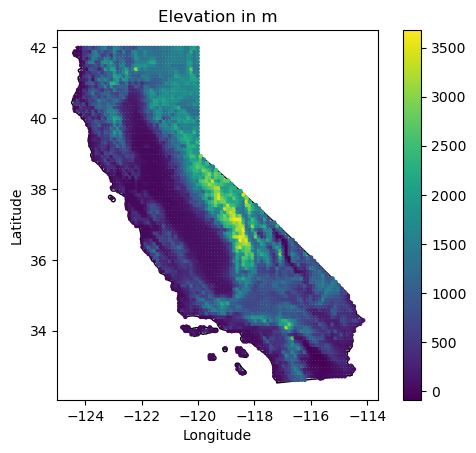

In [35]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the elevation data
ca_elevation_gdf.plot(ax=plt.gca(), column='elevation', legend=True, markersize=5, cmap='viridis')

plt.title('Elevation in m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finally, save the dataframe to a csv file after dropping the 'geometry' column

In [15]:
# Save to CSV
ca_elevation_gdf.drop(columns='geometry').to_csv('ca_elevation.csv', index=False)

In [16]:
#Check
ca_elevation_check = pd.read_csv('ca_elevation.csv')
ca_elevation_check

,lat,lon,elevation
0,37.405176,-122.084769,13
1,37.847173,-122.271529,29
2,37.154450,-121.560230,639
3,38.006981,-122.086832,5
4,38.089888,-122.142635,17
...,...,...,...
4939,34.293795,-114.357804,673
4940,34.392355,-114.357804,281
4941,34.195234,-114.249069,156
4942,34.293795,-114.249069,363


### Add elevation data to the big dataframe

In [26]:
ca_features = pd.read_csv('ca_lc_city_slope.csv')
# ca_features0    = conus_features0.loc[df_main['State']=='CA']
ca_features

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles),slope
0,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160,0
1,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332,1
2,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577,9
3,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221,3
4,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314,27
4940,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006,8
4941,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860,1
4942,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461,9


In [27]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_features, 
    geometry=gpd.points_from_xy(ca_features.lon, ca_features.lat),
    crs="EPSG:4326"
)

# Ensure ca_elevation is a GeoDataFrame with the same CRS
gdf_ca_elevation = gpd.GeoDataFrame(
    ca_elevation_check,
    geometry=gpd.points_from_xy(ca_elevation_check.lon, ca_elevation_check.lat),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features     = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_elevation    = gdf_ca_elevation.to_crs("EPSG:3310")


In [28]:
# Perform the spatial join to find the nearest neighbors and get their 'elevation'
ca_features_with_elevation = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_elevation[['geometry', 'elevation']], how='left', distance_col='distance')

# If you don't need the distance information, drop the 'distance' column
ca_features_with_elevation.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_elevation = ca_features_with_elevation.to_crs("EPSG:4326")

ca_features_with_elevation

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles),slope,geometry,elevation
0,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160,0,POINT (-122.08477 37.40518),13
1,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332,1,POINT (-122.27153 37.84717),29
2,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577,9,POINT (-121.56023 37.15445),639
3,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221,3,POINT (-122.08683 38.00698),5
4,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706,2,POINT (-122.14264 38.08989),17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314,27,POINT (-114.35780 34.29379),673
4940,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006,8,POINT (-114.35780 34.39236),281
4941,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860,1,POINT (-114.24907 34.19523),156
4942,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461,9,POINT (-114.24907 34.29379),363


In [29]:
ca_features_with_elevation.loc[ca_features_with_elevation['land_cover']==1.0]['elevation']

1        29
2       639
4        17
7        44
8        38
       ... 
4939    673
4940    281
4941    156
4942    363
4943    138
Name: elevation, Length: 3677, dtype: int64

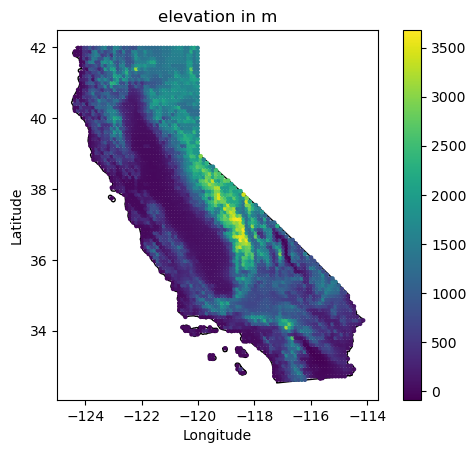

In [34]:
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the elevation data
ca_features_with_elevation.plot(ax=plt.gca(), column='elevation', legend=True, markersize=5, cmap='viridis',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })

plt.title('elevation in m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Finally, save this data as a CSV file

In [32]:
ca_features_with_elevation.drop(columns='geometry').to_csv('ca_lc_city_slope_elevation.csv', index=False)

In [33]:
ca_features_with_elevation_check = pd.read_csv('ca_lc_city_slope_elevation.csv')
ca_features_with_elevation_check 

,lat,lon,State,panel.area,power,panels,landscape.area,water,urban,Address,demand_10km_MWh,demand_20km_MWh,demand_50km_MWh,land_cover,min distance to city (in miles),slope,elevation
0,37.405176,-122.084769,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"1625 San Luis Ave, Mountain View, CA 94043, USA",5.801625e+06,1.021578e+07,1.054983e+07,0.0,1.4160,0,13
1,37.847173,-122.271529,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3372 Martin Luther King Jr Way, Berkeley, CA 9...",5.308202e+06,6.235440e+06,7.062910e+06,1.0,3.3332,1,29
2,37.154450,-121.560230,CA,0.000141,NaN,1.0,0.0,0.0,0.0,"16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA",4.974155e+06,4.974155e+06,9.388313e+06,1.0,33.7577,9,639
3,38.006981,-122.086832,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"150 Nardi Ln, Martinez, CA 94553, USA",4.974155e+06,4.974155e+06,6.235440e+06,0.0,11.8221,3,5
4,38.089888,-122.142635,CA,0.000141,NaN,1.0,0.0,0.0,1.0,"3VQ4+XW Benicia, CA, USA",4.974155e+06,4.974155e+06,6.235440e+06,1.0,16.3706,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,34.293795,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,240.5314,27,673
4940,34.392355,-114.357804,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,269.8006,8,281
4941,34.195234,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,222.2860,1,156
4942,34.293795,-114.249069,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.974155e+06,4.974155e+06,4.974155e+06,1.0,243.1461,9,363
